# Visualize all prediction accuracies from empirical analyses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
# import tools
import nibabel as nib
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Arial"
import pandas as pd
import time
from importlib import reload
import wbplot
import matplotlib.image as img 
import matplotlib.colors as clrs
from matplotlib import colorbar

# Set parameters

In [2]:
networkdef = np.loadtxt('../../data/cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('../../data/cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])
    
glasser = np.squeeze(nib.load('../../data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii').get_fdata())

figuredir = '../../docs/figures/manuscriptFigures/RandomHiddenLayers/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

# Load in data

In [7]:
datadir = '../../data/results/MAIN/srModelPredictionAccuracies/'
labels = ['Motor decoding', 'Motor decoding (null)', 
          'S-R Model', 'S-R Model (null)', 
          'FC shuffling', 'No ReLU',
          'Context lesion',
          'No hidden']

## Load in data
# Create data dict
acc_dict = {}
acc_dict['Hand'] = []
acc_dict['Model'] = []
acc_dict['Accuracy'] = []
##
rh = []
lh = []
hidden_regions = []
# S-R model no hidden layer
for i in range(1,1001):

    rh.append(np.loadtxt(datadir + 'SRActFlowRandomizedHidden_v2/RH_decoding' + str(i) + '.txt')*100.0)
    lh.append(np.loadtxt(datadir + 'SRActFlowRandomizedHidden_v2/LH_decoding' + str(i) + '.txt')*100.0)
    hidden_regions.append(np.loadtxt(datadir + 'SRActFlowRandomizedHidden_v2/HiddenRegionList' + str(i) + '.txt'))

        
rh = np.asarray(rh)
lh = np.asarray(lh)
hidden_regions = np.asarray(hidden_regions)
#         print(i)
# for i in range(len(rh)):
#     acc_dict['Model'].append('Random hidden')
#     acc_dict['Hand'].append('Right hand')
#     acc_dict['Accuracy'].append(rh[i])
# for i in range(len(lh)):
#     acc_dict['Model'].append('Random hidden')
#     acc_dict['Hand'].append('Left hand')
#     acc_dict['Accuracy'].append(lh[i])
    

In [10]:
hiddendir = '../../data/results/MAIN/RSA/'
sorted_hidden_regions = np.loadtxt(hiddendir + 'RSA_Similarity_SortedRegions2.txt')


# How many of the randomly selected regions overlapped with the ANN-derived hidden layer

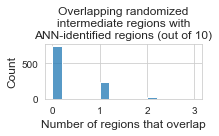

In [21]:
n_overlap = []
for hid in hidden_regions:
    n_overlap.append(len(np.intersect1d(hid,np.asarray(sorted_hidden_regions[:10],dtype=int))))
    
plt.figure(figsize=(3,2))
ax = sns.histplot(n_overlap)
plt.title('Overlapping randomized\nintermediate regions with\nANN-identified regions (out of 10)',fontsize=12)
plt.xlabel('Number of regions that overlap',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.tight_layout()
plt.savefig(figuredir + 'DistributionRandomXANN-derived_Histogram.png',dpi=300)
    

# Sort into top n regions with best decoding

In [12]:
rh_sorted = sorted(range(len(rh)), key=lambda k: rh[k])
lh_sorted = sorted(range(len(lh)), key=lambda k: lh[k])
nsimulations = 50
rh_top10 = rh_sorted[-nsimulations:]
lh_top10 = lh_sorted[-nsimulations:]
# rh_top10 = rh_sorted[:]
# lh_top10 = lh_sorted[:]

df_random = {}
df_random['Region'] = []
df_random['Network'] = []
df_random['Hand'] = []
for sim in rh_top10:
    regions = hidden_regions[sim]
    for region in regions:
        df_random['Region'].append(region)
        df_random['Network'].append(int(networkdef[int(region)]))
        df_random['Hand'].append('RH')
        
for sim in lh_top10:
    regions = hidden_regions[sim]
    for region in regions:
        df_random['Region'].append(region)
        df_random['Network'].append(int(networkdef[int(region)]))
        df_random['Hand'].append('LH')

df_random = pd.DataFrame(df_random)

tmprh = df_random[df_random['Hand']=='RH']
tmprh = tmprh.Region.values
count_rh = np.zeros((nParcels,))
for roi in range(nParcels):
    count_rh[roi] = np.where(tmprh==roi)[0].shape[0]
    
tmplh = df_random[df_random['Hand']=='LH']
tmplh = tmplh.Region.values
count_lh = np.zeros((nParcels,))
for roi in range(nParcels):
    count_lh[roi] = np.where(tmplh==roi)[0].shape[0]
    

## See which networks contribute to successful predictions and compare to ANN results

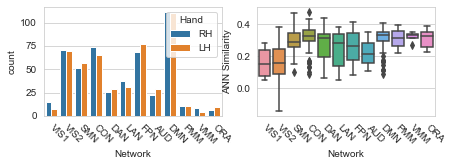

In [13]:
# Load in ANN results
hiddendir = '../../data/results/MAIN/RSA/'
sorted_hidden_regions = np.loadtxt(hiddendir + 'RSA_Similarity_SortedRegions2.txt')
hidden_region_score_64k = np.loadtxt(hiddendir + 'rsaSimilarity_v2.csv')
hidden_region_score = []
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    hidden_region_score.append(np.mean(hidden_region_score_64k[roi_ind]))
hidden_region_score = np.asarray(hidden_region_score)
rsa_hidden = {}
rsa_hidden['Region'] = []
rsa_hidden['Network'] = []
rsa_hidden['ANN Similarity'] = []
for roi in range(nParcels):
    rsa_hidden['Region'].append(roi+1)
    rsa_hidden['Network'].append(int(networkdef[int(roi)]))
    rsa_hidden['ANN Similarity'].append(hidden_region_score[roi])
rsa_hidden = pd.DataFrame(rsa_hidden)

fig = plt.figure(figsize=(7,2))
ax1 = fig.add_subplot(121)
# g = sns.catplot(x='Network',hue="Hand",kind='count',data=df_random,ax=ax1)
g = sns.countplot(x='Network',hue="Hand",data=df_random,ax=ax1)
plt.xticks(np.arange(0.5,12.5),OrderedNetworks,rotation=-45,fontsize=10);

ax2 = fig.add_subplot(122)
g = sns.boxplot(x='Network',y="ANN Similarity",data=rsa_hidden,ax=ax2)
plt.xticks(np.arange(0.5,12.5),OrderedNetworks,rotation=-45,fontsize=10);

# plt.xticks(np.arange(12),np.arange(1,13))


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


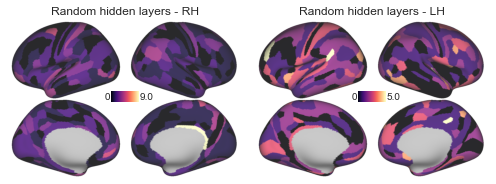

In [75]:
vmin, vmax = 0, np.max(count_rh)
tmp = np.hstack((count_rh[180:],count_rh[:180]))
wbplot.pscalar(figuredir + 'RHcount_RandomHiddenLayers.png',tmp,vrange=(vmin,vmax),cmap='magma')

vmin, vmax = 0, np.max(count_lh)
tmp = np.hstack((count_lh[180:],count_lh[:180]))
wbplot.pscalar(figuredir + 'LHcount_RandomHiddenLayers.png',tmp,vrange=(vmin,vmax),cmap='magma')


fig = plt.figure(figsize=(7,4))

ax = plt.subplot(1,2,1)
im = img.imread(figuredir + 'RHcount_RandomHiddenLayers.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Random hidden layers - RH',fontsize=12)
vmin, vmax = 0, np.max(count_rh)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=10,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=10,fontname='Arial');
plt.tight_layout()

ax = plt.subplot(1,2,2)
im = img.imread(figuredir + 'LHcount_RandomHiddenLayers.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Random hidden layers - LH',fontsize=12)
vmin, vmax = 0, np.max(count_lh)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=10,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=10,fontname='Arial');
plt.tight_layout()
# plt.savefig(figuredir + 'RandomHiddenRegionContributions.png',dpi=300)


#### Measure similarity between top 10% of performing random hidden regions and ANN-derived hidden regions

In [14]:
print("Cosine similarity between top 10% performing hidden regions and ANN-derived hidden regions (by ANN-similarity)")
print('\tRH responses', np.dot(count_rh,hidden_region_score)/(np.linalg.norm(count_rh)*np.linalg.norm(hidden_region_score)))
print('\tLH responses', np.dot(count_lh,hidden_region_score)/(np.linalg.norm(count_lh)*np.linalg.norm(hidden_region_score)))

print("Top-10 ANN-derived regions X top 10% performing randomly selected hidden regions")
top_ind = np.asarray(sorted_hidden_regions[:10],dtype=int)
top = np.zeros((nParcels,))
top[top_ind] = 1
print('\tRH responses', np.dot(count_rh,top)/(np.linalg.norm(count_rh)*np.linalg.norm(top)))
print('\tLH responses', np.dot(count_lh,top)/(np.linalg.norm(count_lh)*np.linalg.norm(top)))

# print("Top-20 ANN-derived regions X top 10% performing randomly selected hidden regions")
# top_ind = np.asarray(sorted_hidden_regions[:20],dtype=int)
# top = np.zeros((nParcels,))
# top[top_ind] = 1
# print('\tRH responses', np.dot(count_rh,top)/(np.linalg.norm(count_rh)*np.linalg.norm(top)))
# print('\tLH responses', np.dot(count_lh,top)/(np.linalg.norm(count_lh)*np.linalg.norm(top)))

Cosine similarity between top 10% performing hidden regions and ANN-derived hidden regions (by ANN-similarity)
	RH responses 0.7141383391284353
	LH responses 0.7013143859486963
Top-10 ANN-derived regions X top 10% performing randomly selected hidden regions
	RH responses 0.17230060940112776
	LH responses 0.09151617004789102


# Run statistical permutation tests to determine p-values

In [15]:
def findHighPerformingRegions(rh_sorted,lh_sorted,percent=.10,permutation=False):
    """Finds the regions contributing to the top-performing motor response decodings for RH/LH"""
    nsimulations = int(len(rh_sorted)*percent)
    if not permutation:
        rh_top10 = rh_sorted[-nsimulations:]
        lh_top10 = lh_sorted[-nsimulations:]
#         rh_top10 = rh_sorted[:nsimulations]
#         lh_top10 = lh_sorted[:nsimulations]
    else:
        ind = np.random.choice(np.arange(len(rh_sorted)),nsimulations,replace=True)
#         ind = np.random.choice(np.arange(len(rh_sorted)-len(rh_sorted[-nsimulations:])),nsimulations,replace=False)        
        rh_top10 = np.asarray(rh_sorted)[ind]
        lh_top10 = np.asarray(lh_sorted)[ind]

    count_rh = np.zeros((nParcels,))
    for sim in rh_top10:
        regions = hidden_regions[sim]
        regions = np.asarray(regions,dtype=int)
        for region in regions:
            count_rh[region] = count_rh[region] + 1
    
    count_lh = np.zeros((nParcels,))
    for sim in lh_top10:
        regions = hidden_regions[sim]
        regions = np.asarray(regions,dtype=int)
        for region in regions:
            count_lh[region] = count_lh[region] + 1
    
    return count_rh, count_lh

def cosineSimilarity(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def distance(x,y,metric='cosine'):
    if metric=='cosine':
        return cosineSimilarity(x,y)
    if metric=='euclidean':
        return np.linalg.norm(x-y)
    if metric=='pearson':
        return stats.pearsonr(x,y)[0]
    if metric=='spearman':
        return stats.spearmanr(x,y)[0]
    if metric=='inner':
        return np.dot(x,y)

In [16]:
percent = 0.1
metric = 'inner'

count_rh, count_lh = findHighPerformingRegions(rh_sorted,lh_sorted,percent=percent,permutation=False)
top_ind = np.asarray(sorted_hidden_regions[:10],dtype=int)
top = np.zeros((nParcels,))
top[top_ind] = 1
# print('\tRH responses', np.dot(count_rh,top)/(np.linalg.norm(count_rh)*np.linalg.norm(top)))
# print('\tLH responses', np.dot(count_lh,top)/(np.linalg.norm(count_lh)*np.linalg.norm(top)))


npermutations = 1000
perm_dist_similarity_rh = []
perm_dist_similarity_lh = []
perm_dist_top10_rh = []
perm_dist_top10_lh = []
for i in range(npermutations):
    tmp_count_rh, tmp_count_lh = findHighPerformingRegions(rh_sorted,lh_sorted,percent=percent,permutation=True)
    # Compute similarity with ANN-similarity score of each region
    perm_dist_similarity_rh.append(distance(tmp_count_rh,np.arctanh(hidden_region_score),metric=metric))
    perm_dist_similarity_lh.append(distance(tmp_count_lh,np.arctanh(hidden_region_score),metric=metric))
    # Compute similarity with top 10 regions with ANN similarity
    perm_dist_top10_rh.append(distance(tmp_count_rh,top,metric=metric))
    perm_dist_top10_lh.append(distance(tmp_count_lh,top,metric=metric))

true_annsimilarity_rh = distance(count_rh,np.arctanh(hidden_region_score),metric=metric)
true_annsimilarity_lh = distance(count_lh,np.arctanh(hidden_region_score),metric=metric)
print("Cosine similarity between top 10% performing hidden regions and ANN-derived hidden regions (by ANN-similarity)")
print('\tRH responses', true_annsimilarity_rh, '| p =', np.mean(np.asarray(perm_dist_similarity_rh)>true_annsimilarity_rh))
print('\tLH responses', true_annsimilarity_lh, '| p =', np.mean(np.asarray(perm_dist_similarity_lh)>true_annsimilarity_lh))

true_top10_rh = distance(count_rh,top,metric=metric)
true_top10_lh = distance(count_lh,top,metric=metric)
print("Top-10 ANN-derived regions X top 10% performing randomly selected hidden regions")
print('\tRH responses', true_top10_rh, '| p =', np.mean(np.asarray(perm_dist_top10_rh)>true_top10_rh))
print('\tLH responses', true_top10_lh, '| p =', np.mean(np.asarray(perm_dist_top10_lh)>true_top10_lh))

Cosine similarity between top 10% performing hidden regions and ANN-derived hidden regions (by ANN-similarity)
	RH responses 279.44366898229 | p = 0.529
	LH responses 276.95992860884974 | p = 0.798
Top-10 ANN-derived regions X top 10% performing randomly selected hidden regions
	RH responses 31.0 | p = 0.27
	LH responses 24.0 | p = 0.767


# Compute overlap of top x percent versus randomly selected units

In [56]:
def countOverlapWithHidden(rh_sorted,lh_sorted,percent=.10,permutation=False,metric='cosine'):
    """Finds the regions contributing to the top-performing motor response decodings for RH/LH"""
    # Define the 'true' ANN-maximized similarity regions
    top10 = sorted_hidden_regions[:10]    
    
    nsimulations = int(len(rh_sorted)*percent)
    if not permutation:
        rh_top10 = rh_sorted[-nsimulations:]
        lh_top10 = lh_sorted[-nsimulations:]
    else:
#         ind = np.random.choice(np.arange(len(rh_sorted)),nsimulations,replace=True)
        ind = np.random.choice(np.arange(len(rh_sorted)-len(rh_sorted[-nsimulations:])),nsimulations,replace=True)
        rh_top10 = np.asarray(rh_sorted)[ind]
        lh_top10 = np.asarray(lh_sorted)[ind]

    overlap_rh = np.zeros((nsimulations,))
    i = 0
    for sim in rh_top10:
        regions = hidden_regions[sim]
        regions = np.asarray(regions,dtype=int)
        overlap_rh[i] = len(np.intersect1d(top10,regions))
        i += 1
    
    overlap_lh = np.zeros((nsimulations,))
    i = 0
    for sim in lh_top10:
        regions = hidden_regions[sim]
        regions = np.asarray(regions,dtype=int)
        overlap_lh[i] = len(np.intersect1d(top10,regions))
        i += 1
        
    return overlap_rh, overlap_lh


# Count number of overlapping hidden regions for each accurcy score

In [66]:
top_ind = np.asarray(sorted_hidden_regions[:10],dtype=int)
top = np.zeros((nParcels,))
top[top_ind] = 1

df_countVaccuracy_rh = {}
df_countVaccuracy_rh['Overlap'] = []
df_countVaccuracy_rh['Accuracy'] = []
for i in range(len(hidden_regions)):
    ind = np.asarray(hidden_regions[i],dtype=int)
#     df_countVaccuracy_rh['Overlap'].append(np.mean(hidden_region_score[ind]))
    df_countVaccuracy_rh['Overlap'].append(len(np.intersect1d(top_ind,hidden_regions[i])))
    df_countVaccuracy_rh['Accuracy'].append(rh[i])

df_countVaccuracy_lh = {}
df_countVaccuracy_lh['Overlap'] = []
df_countVaccuracy_lh['Accuracy'] = []
for i in range(len(hidden_regions)):
    hid = np.zeros((nParcels,))
    ind = np.asarray(hidden_regions[i],dtype=int)
    hid[ind] = 1
    df_countVaccuracy_lh['Overlap'].append(len(np.intersect1d(top_ind,hidden_regions[i])))
#     df_countVaccuracy_lh['Overlap'].append(np.mean(hidden_region_score[ind]))
    df_countVaccuracy_lh['Accuracy'].append(lh[i])
    
df_countVaccuracy_lh = pd.DataFrame(df_countVaccuracy_lh)
df_countVaccuracy_rh = pd.DataFrame(df_countVaccuracy_rh)

<AxesSubplot:xlabel='Accuracy', ylabel='Overlap'>

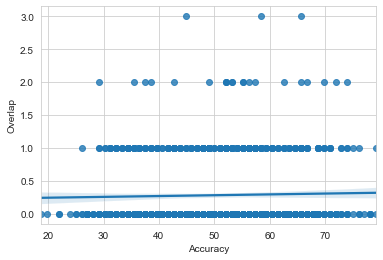

In [120]:
sns.regplot(x="Accuracy",y="Overlap",data=df_countVaccuracy_rh)

# higher ANN similarity -> better accuracy?

In [60]:
top10

array([113., 279., 116., 216., 293., 226., 104.,  76., 208., 221.])

In [18]:
top_ind = np.asarray(sorted_hidden_regions[:10],dtype=int)
top = np.zeros((nParcels,))
top[top_ind] = 1

df_countVaccuracy_rh = {}
df_countVaccuracy_rh['ANN similarity'] = []
df_countVaccuracy_rh['Accuracy'] = []
df_countVaccuracy_rh['Permutation'] = []
df_countVaccuracy_rh['Models'] = []
for i in range(len(hidden_regions)):
    ind = np.asarray(hidden_regions[i],dtype=int)
    df_countVaccuracy_rh['ANN similarity'].append(np.mean(hidden_region_score[ind]))
    df_countVaccuracy_rh['Accuracy'].append(rh[i])
    df_countVaccuracy_rh['Permutation'].append('Permutation')
    df_countVaccuracy_rh['Models'].append("Model")
# Include 'true' results
df_countVaccuracy_rh['ANN similarity'].append(np.mean(hidden_region_score[top_ind]))
df_countVaccuracy_rh['Accuracy'].append(64.11)
df_countVaccuracy_rh['Permutation'].append('ANN-derived')
df_countVaccuracy_rh['Models'].append("Model")

df_countVaccuracy_lh = {}
df_countVaccuracy_lh['ANN similarity'] = []
df_countVaccuracy_lh['Accuracy'] = []
df_countVaccuracy_lh['Permutation'] = []
for i in range(len(hidden_regions)):
    hid = np.zeros((nParcels,))
    ind = np.asarray(hidden_regions[i],dtype=int)
    hid[ind] = 1
    df_countVaccuracy_lh['ANN similarity'].append(np.mean(hidden_region_score[ind]))
    df_countVaccuracy_lh['Accuracy'].append(lh[i])
    df_countVaccuracy_lh['Permutation'].append('Permutation')

# Include 'true' results
df_countVaccuracy_lh['ANN similarity'].append(np.mean(hidden_region_score[top_ind]))
df_countVaccuracy_lh['Accuracy'].append(79.83)
df_countVaccuracy_lh['Permutation'].append('ANN-derived')
    
df_countVaccuracy_lh = pd.DataFrame(df_countVaccuracy_lh)
df_countVaccuracy_rh = pd.DataFrame(df_countVaccuracy_rh)

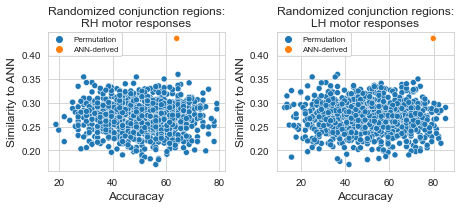

In [128]:
plt.figure(figsize=(6.5,3))
plt.subplot(121)
plt.title('Randomized conjunction regions:\nRH motor responses',fontsize=12)
ax = sns.scatterplot(x="Accuracy",y="ANN similarity",hue='Permutation',data=df_countVaccuracy_rh)
# sns.regplot(x="Accuracy",y="ANN similarity",data=df_countVaccuracy_rh,scatter=False)
plt.xlabel('Model performance: Accuracy',fontsize=12)
plt.ylabel('Similarity to ANN',fontsize=12)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=2, borderaxespad=0., prop={'size': 8})

plt.subplot(122)
plt.title('Randomized conjunction regions:\nLH motor responses',fontsize=12)
ax = sns.scatterplot(x="Accuracy",y="ANN similarity",hue='Permutation',data=df_countVaccuracy_lh)
# sns.regplot(x="Accuracy",y="ANN similarity",data=df_countVaccuracy_lh,scatter=False)
plt.xlabel('Model performance: Accuracy',fontsize=12)
plt.ylabel('Similarity to ANN',fontsize=12)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=2, borderaxespad=0., prop={'size': 8})

plt.tight_layout()
plt.savefig(figuredir + 'Similarity2ANNvsAccuracy_Randomized.png',dpi=300)

/Users/tito/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 64.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


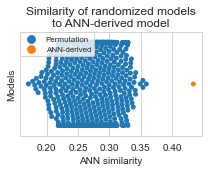

In [19]:
plt.figure(figsize=(3,2.5))
plt.title('Similarity of randomized models\nto ANN-derived model',fontsize=12)
ax = sns.swarmplot(y="Models",x="ANN similarity",hue='Permutation',data=df_countVaccuracy_rh)
plt.yticks([])
# sns.regplot(x="Accuracy",y="ANN similarity",data=df_countVaccuracy_rh,scatter=False)
# plt.xlabel('Model performance: Accuracy',fontsize=12)
# plt.ylabel('Similarity to ANN',fontsize=12)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=2, borderaxespad=0., prop={'size': 8})

plt.tight_layout()
plt.savefig(figuredir + 'RandomizedModelsSimilarity2ANN.png',dpi=300)